This is a quick example showing how to use the code with the ISBI 2012 data set.

Note that the sample weights provided here are *not* the best possible - for best results one would want to train for longer.

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
from socket import gethostname

import numpy as np
import pylab as plt
import matplotlib.gridspec as gridspec

np.random.seed(9999)

import keras
from keras import backend as K
from keras.models import load_model

sys.path.append('../..')
from cnn_tools import *
from data_tools import *


K.set_image_dim_ordering('th')

print('Using Keras version: %s' % keras.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using Keras version: 2.0.2


In [2]:
# load data
isbi_dir = os.path.expanduser('~/Data/ISBI-2012')
X_test = load_multilayer_tiff(os.path.join(isbi_dir, 'test-volume.tif'))
X_test /= 255.

X_train = load_multilayer_tiff(os.path.join(isbi_dir, 'train-volume.tif'))
X_train /= 255.

Y_train = load_multilayer_tiff(os.path.join(isbi_dir, 'train-labels.tif'))
Y_train[Y_train==255] = 1

print('[info]: test data has shape:     ', X_test.shape)
print('[info]: train data has shape:     ', X_train.shape)

# load model
model = create_unet((1, 256, 256))
model.load_weights('./weights_epoch0011.hdf5')

print('[info]: model input shape: ', model.input_shape)

[info]: test data has shape:      (30, 1, 512, 512)
[info]: train data has shape:      (30, 1, 512, 512)
[info]: model input shape:  (None, 1, 256, 256)


In [15]:
# deploy on test data
tic = time.time()

Y_hat_test = deploy_model(X_test, model, two_pass=True)

print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))
print('[info]: Y_hat shape: ', Y_hat_test.shape)

[info]: total time to deploy on system "pekalmj1-ml2": 207.94 sec
[info]: Y_hat shape:  (30, 2, 512, 512)


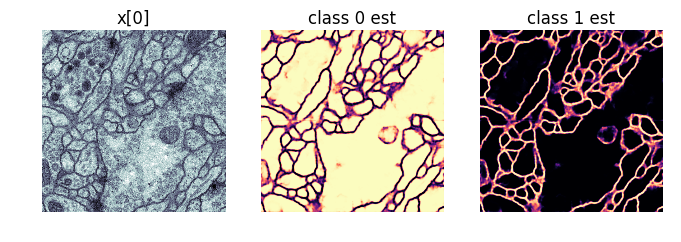

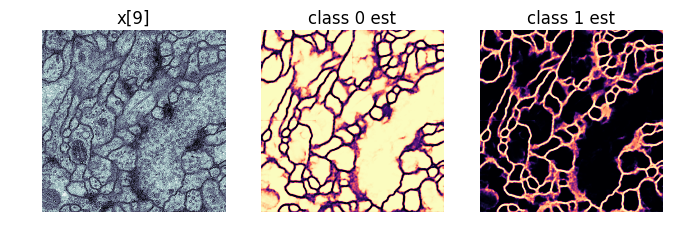

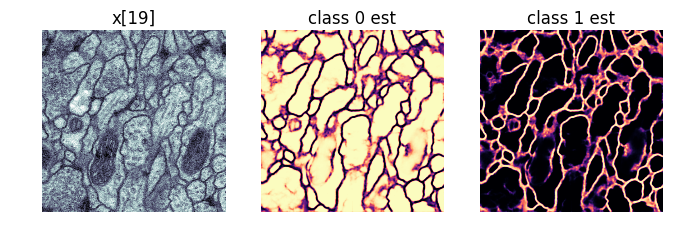

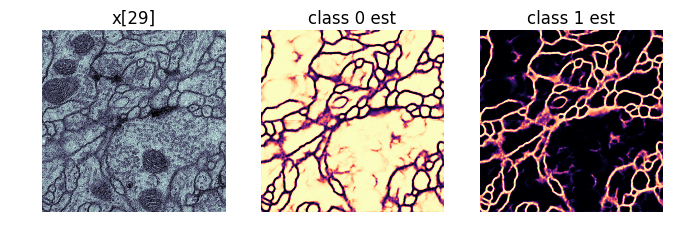

1.0
4.27566e-07


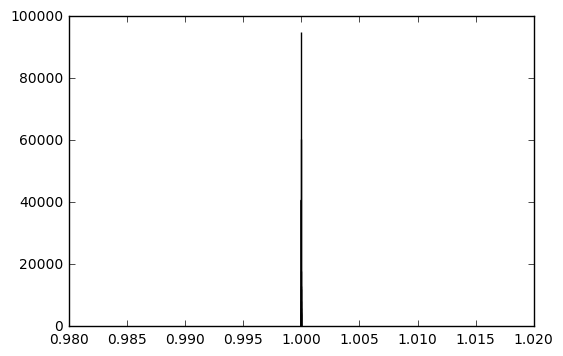

In [17]:
# visualize performance on test data
# Note: ISBI does not make truth available for test data.

for z in [0, 9, 19, 29]:
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.imshow(X_test[z,0,...], cmap='bone'); plt.axis('off')
    plt.title('x[%d]' % z)
    plt.subplot(1,3,2)
    plt.imshow(Y_hat_test[z,0,...], cmap='magma'); plt.axis('off')
    plt.title('class 0 est')
    plt.subplot(1,3,3)
    plt.imshow(Y_hat_test[z,1,...], cmap='magma'); plt.axis('off')
    plt.title('class 1 est')
    plt.show()
    
# make sure the classification layers are as expected
net0 = Y_hat_test[0,0,...] + Y_hat_test[0,1,...]

plt.figure()
plt.hist(net0.flatten())
plt.xlim((.98, 1.02))

print(np.mean(net0))
print(np.std(net0))


In [22]:
# deploy on train data
tic = time.time()
Y_hat_train = deploy_model(X_train, model)
Y_hat_train_2 = deploy_model(X_train, model, two_pass=True)
print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))
print('[info]: Y_hat shape: ', Y_hat_train.shape)

[info]: total time to deploy on system "pekalmj1-ml2": 311.08 sec
[info]: Y_hat shape:  (30, 2, 512, 512)


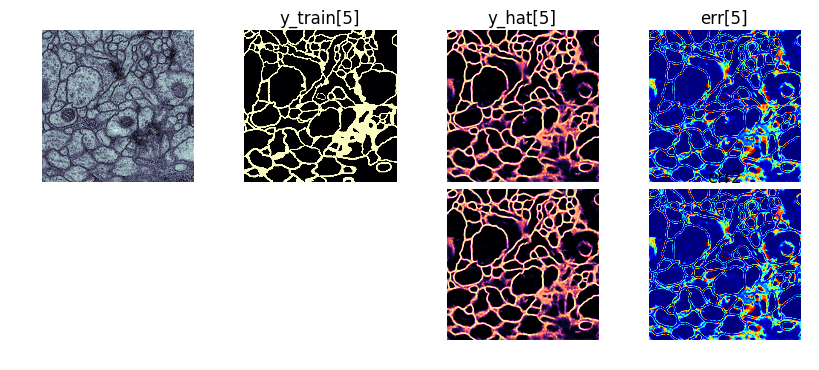

In [79]:
# also take a quick look at some training data

for z in [5,]:
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,4,1)
    plt.imshow(X_train[z,0,...], cmap='bone'); plt.axis('off')
    
    plt.subplot(2,4,2)
    plt.imshow(1-Y_train[z,0,...], cmap='magma'); plt.axis('off')
    plt.title('y_train[%d]' % z)
    
    plt.subplot(2,4,3)
    plt.imshow(Y_hat_train[z,1,...], cmap='magma'); plt.axis('off')
    plt.title('y_hat[%d]' % z)
    
    plt.subplot(2,4,4)
    plt.imshow(np.abs(Y_hat_train[z,1,...] - (1-Y_train[z,0,...])), cmap='jet'); plt.axis('off')
    plt.title('err[%d]' % z)
    
    plt.subplot(2,4,7)
    plt.imshow(Y_hat_train_2[z,1,...], cmap='magma'); plt.axis('off')
    
    plt.subplot(2,4,8)
    plt.imshow(np.abs(Y_hat_train_2[z,1,...] - (1-Y_train[z,0,...])), cmap='jet'); plt.axis('off')
    plt.title('err2')
    
    plt.subplots_adjust(hspace=.05)
    plt.show();